# Virtual the growth plate from single-cell transcriptomic data

In [1]:
import scanpy as sc, anndata as ad

import openTSNE
import boundary_utils as bu

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
filename = 'GP.h5ad'
adata = sc.read_h5ad(filename)
adata

AnnData object with n_obs × n_vars = 15096 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Strain', 'Sex', 'Tissue', 'Technology', 'Author', 'CellType', 'Study', 'Batch', 'DevTP', '_scvi_batch', '_scvi_labels', 'NandC', 'Numbers', 'pseudotime'
    var: 'name', 'mvp.mean', 'mvp.dispersion', 'mvp.dispersion.scaled', 'highly.variable_nbatches', 'highly.variable_intersection'
    obsm: 'X_mde', 'X_mde_scanvi', 'X_pca', 'X_scanvi', 'X_scvi', 'X_umap'

In [3]:
sc.tl.pca(adata)

Where n_obs × n_vars = 3474 × 40632 -> 3474 and 40632 genes. PCA components and pseudotime value are defined for each cell

In [4]:
pca_data = adata.obsm['X_pca']
pca_data.shape

(15096, 50)

In [5]:
pseudotime = adata.obs['pseudotime']
pseudotime.shape

(15096,)

In [6]:
adata.obs['CellType'] = adata.obs['CellType'].cat.remove_unused_categories()

Parameters of the circle boundary function which confines TSNE output

In [7]:
radius = 5
y_center = 2.5
n_slices = 50

## Bounded embedding during TSNE dimensionality reduction

Adaptation of the "t-SNE Animations" tutorial from creators of openTSNE:

https://github.com/pavlin-policar/openTSNE/blob/master/examples/05_animation.ipynb

In [8]:
x = pca_data

### TSNE without confined embedding

In [9]:
def set_boundary_embedding(emb, embeddings):
    embeddings.append(np.array(emb))

We pass a callback that will take the current embedding, make a copy (this is important because the embedding is changed inplace during optimization) and add it to a list. We can also specify how often the callbacks should be called. In this instance, we'll call it at every iteration.

In [10]:
embeddings = []

tsne = openTSNE.TSNE(
    perplexity=50, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: set_boundary_embedding(emb, embeddings),
    # This should be done on every iteration
    callbacks_every_iters=1,
)

In [11]:
%time tsne_embedding = tsne.fit(x)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f37806d56c0>, callbacks_every_iters=1,
     metric='cosine', n_jobs=32, perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 5.61 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=1258.00 for 250 iterations...
Iteration   50, KL divergence 4.4821, 50 iterations in 1.2809 sec
Iteration  100, KL divergence 4.0681, 50 iterations in 1.2279 sec
Iteration  150, KL divergence 3.9568, 50 iterations in 1.1897 sec
Iteration  200, KL divergence 3.9047, 50 iterations in 1.2978 sec
Iteration  250, KL divergence 3.8759, 50 iterations in 1.2638 sec
   --> Ti

In [12]:
adata.obsm['X_tsne'] = embeddings[-1]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


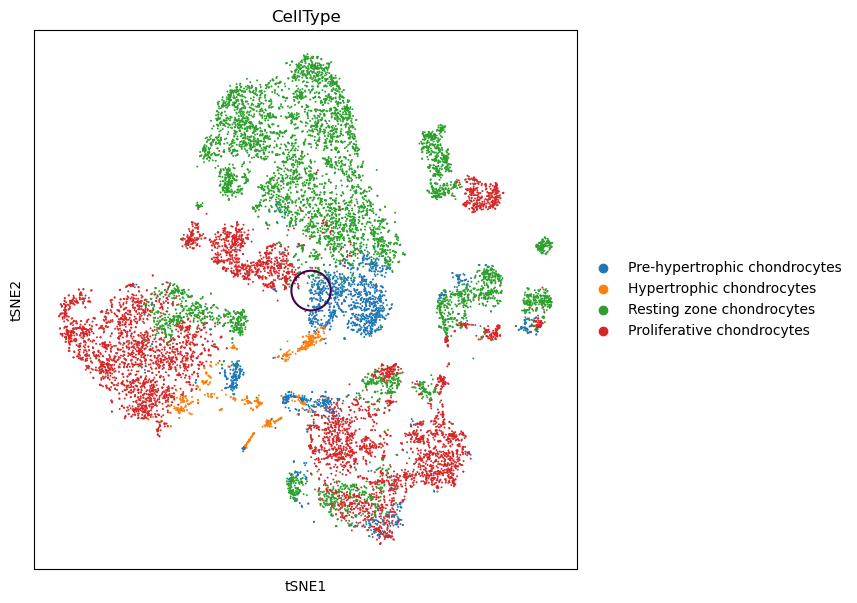

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))

a = np.linspace(-60, 60, 1000)
b = np.linspace(-60, 60, 1000)
A, B = np.meshgrid(a,b)

ax.contour(A, B, bu.boundary_circle(A, B, radius = radius, y_center = y_center) ,[0])

sc.pl.tsne(adata, color='CellType', ax=ax)

ax.set_aspect('equal')

### TSNE with circular embedding

In [14]:
buondary_function = lambda x , y : bu.boundary_circle(x, y, radius = radius, y_center = y_center)

def set_boundary_embedding(emb, embeddings, boundary_function):
    outside_boundary = buondary_function(emb[:,0], emb[:,1]) < 0
    if any(outside_boundary):
        output = list(map(lambda point : bu.closest_point_in_function(point, buondary_function), emb[outside_boundary]))
        emb[outside_boundary] = np.array(output)
    embeddings.append(np.array(emb))

We pass a callback that will take the current embedding, make a copy (this is important because the embedding is changed inplace during optimization) and add it to a list. We can also specify how often the callbacks should be called. In this instance, we'll call it at every iteration.

In [15]:
embeddings = []

tsne = openTSNE.TSNE(
    perplexity=50, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: set_boundary_embedding(emb, embeddings, buondary_function),
    # This should be done on every iteration
    callbacks_every_iters=1,
)

In [16]:
%time tsne_embedding = tsne.fit(x)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f37746d9e10>, callbacks_every_iters=1,
     metric='cosine', n_jobs=32, perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 5.92 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=1258.00 for 250 iterations...
Iteration   50, KL divergence 4.4815, 50 iterations in 1.4433 sec
Iteration  100, KL divergence 4.0937, 50 iterations in 18.2680 sec
Iteration  150, KL divergence 4.0300, 50 iterations in 68.7776 sec
Iteration  200, KL divergence 4.0154, 50 iterations in 117.7888 sec
Iteration  250, KL divergence 4.0063, 50 iterations in 131.8865 sec
   

In [17]:
adata.obsm['X_tsne'] = embeddings[-1]

/opt/conda/envs/sc-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


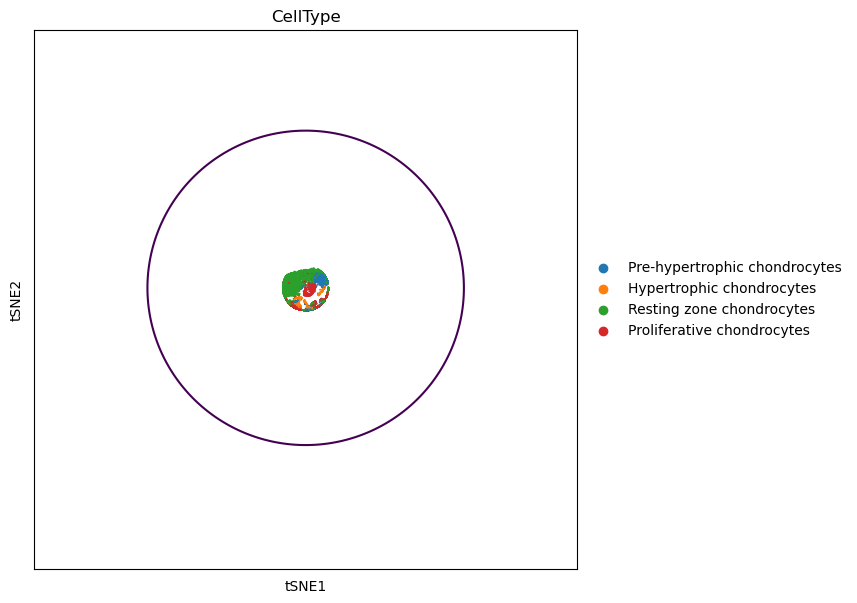

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))

a = np.linspace(-60, 60, 1000)
b = np.linspace(-60, 60, 1000)
A, B = np.meshgrid(a,b)

ax.contour(A, B, bu.boundary_circle(A, B, radius = 35, y_center = 2.5) ,[0])

sc.pl.tsne(adata, color='CellType', ax=ax)

ax.set_aspect('equal')

Plotting a 3D Scatter Plot in Seaborn

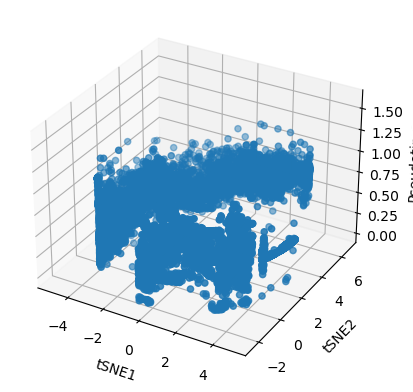

In [19]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = adata.obsm['X_tsne'][:,0]
y = adata.obsm['X_tsne'][:,1]
z = adata.obs['pseudotime']

ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
ax.set_zlabel("Pseudotime")

ax.scatter(x, y, z)

### TSNE slices with circular embedding

cut is used to bin pandas DataFrame and specifically define the bin edges. There is no guarantee about the distribution of items in each bin. In fact, you can define bins in such a way that no items are included in a bin or nearly all items are in a single bin.

https://pbpython.com/pandas-qcut-cut.html

In [20]:
adata.obs['cut_pseudotime'] = pd.cut(adata.obs['pseudotime'], bins=n_slices, include_lowest=True)

After binning the adata object, we separate each bin and run the TSNE dimentionsality reduction with circular embedding. After, the output of the embedded TSNEs will be concatenated and merged.

 - Concatenation is when we keep all sub elements of each object, and stack these elements in an ordered way.

 - Merging is combining a set of collections into one resulting collection which contains elements from the objects.

https://anndata.readthedocs.io/en/latest/concatenation.html

In [21]:
df_tsne = pd.DataFrame(columns = ['idx', 'X_tsne_sliced'])

adatas = []

for count, item in enumerate(adata.obs.groupby('cut_pseudotime').indices.items()):
    print(f'Slice number: {count}')
    group, idx = item
    
    if idx.size == 0:
            df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': []}, ignore_index=True)
    else:
        sub_adata = adata[idx].copy()
    
        bu.circular_openTSNE(sub_adata, radius = radius, y_center = y_center)

        df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
        
        adatas.append(sub_adata)

Slice number: 0
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5360>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.1027, 50 iterations in 0.2921 sec
Iteration  100, KL divergence 2.0904, 50 iterations in 0.1590 sec
Iteration  150, KL divergence 2.0891, 50 iterations in 0.0822 sec
Iteration  200, KL divergence 2.0896, 50 iterations in 0.1939 sec
Iteration  250, KL divergence 2.0892, 50

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 20.33 instead


Iteration  500, KL divergence 0.9463, 50 iterations in 9.1162 sec
   --> Time elapsed: 83.82 seconds
Slice number: 1
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5bd0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 61 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4644, 50 iterations in 0.4994 sec
Iteration  100, KL divergence 1.3379, 50 iterations in 0.3812 sec
Iteration  150, KL divergence 1.2603, 50 iterations in 0.2813 sec
Iterat

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 24.33 instead


Iteration  500, KL divergence 0.1261, 50 iterations in 1.1104 sec
   --> Time elapsed: 10.34 seconds
Slice number: 2
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5360>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 73 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.2499, 50 iterations in 0.5663 sec
Iteration  100, KL divergence 1.3997, 50 iterations in 0.3599 sec
Iteration  150, KL divergence 1.5922, 50 iterations in 0.3226 sec
Iterat

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 48.33 instead


Iteration  500, KL divergence 0.2084, 50 iterations in 1.1756 sec
   --> Time elapsed: 11.61 seconds
Slice number: 3
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5360>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 145 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.1868, 50 iterations in 0.2753 sec
Iteration  100, KL divergence 1.2355, 50 iterations in 0.1657 sec
Iteration  150, KL divergence 1.1531, 50 iterations in 0.1806 sec
Itera

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.3306, 50 iterations in 0.2215 sec
Iteration  100, KL divergence 1.2927, 50 iterations in 0.1389 sec
Iteration  150, KL divergence 1.3418, 50 iterations in 0.1510 sec
Iteration  200, KL divergence 1.3190, 50 iterations in 0.1953 sec
Iteration  250, KL divergence 1.2736, 50 iterations in 0.1286 sec
   --> Time elapsed: 0.84 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4327, 50 iterations in 1.3937 sec
Iteration  100, KL divergence 0.4199, 50 iterations in 1.5806 sec
Iteration  150, KL divergence 0.4136, 50 iterations in 1.9123 sec
Iteration  200, KL divergence 0.4033, 50 iterations in 1.9907 sec
Iteration  250, KL divergence 0.4031, 50 iterations in 1.9954 sec
Iteration  300, KL divergence 0.4035, 50 iterations in 1.9549 sec
Iteration  350, KL divergence 0.4033, 50 iterations in 1.9247 sec
Iteration  400, KL divergence 0.4033, 50 iterations in 1.9215 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 40.00 instead


Iteration  500, KL divergence 0.4034, 50 iterations in 1.8872 sec
   --> Time elapsed: 18.47 seconds
Slice number: 5
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c7d00>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 120 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3617, 50 iterations in 0.5535 sec
Iteration  100, KL divergence 1.3826, 50 iterations in 0.2282 sec
Iteration  150, KL divergence 1.1779, 50 iterations in 0.1276 sec
Itera

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.0876, 50 iterations in 0.2373 sec
Iteration  100, KL divergence 1.0531, 50 iterations in 0.0758 sec
Iteration  150, KL divergence 1.0792, 50 iterations in 0.1434 sec
Iteration  200, KL divergence 1.0575, 50 iterations in 0.0936 sec
Iteration  250, KL divergence 1.0519, 50 iterations in 0.1317 sec
   --> Time elapsed: 0.68 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.2058, 50 iterations in 3.3126 sec
Iteration  100, KL divergence 0.1971, 50 iterations in 5.0120 sec
Iteration  150, KL divergence 0.1968, 50 iterations in 4.9785 sec
Iteration  200, KL divergence 0.1967, 50 iterations in 4.6999 sec
Iteration  250, KL divergence 0.1971, 50 iterations in 4.6593 sec
Iteration  300, KL divergence 0.1969, 50 iterations in 4.7528 sec
Iteration  350, KL divergence 0.1967, 50 iterations in 4.7641 sec
Iteration  400, KL divergence 0.1970, 50 iterations in 4.6582 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.0512, 50 iterations in 0.1555 sec
Iteration  100, KL divergence 0.9723, 50 iterations in 0.0559 sec
Iteration  150, KL divergence 0.9670, 50 iterations in 0.1535 sec
Iteration  200, KL divergence 0.9555, 50 iterations in 0.0866 sec
Iteration  250, KL divergence 0.9624, 50 iterations in 0.0655 sec
   --> Time elapsed: 0.52 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.3187, 50 iterations in 3.6994 sec
Iteration  100, KL divergence 0.2961, 50 iterations in 5.0585 sec
Iteration  150, KL divergence 0.2957, 50 iterations in 5.1248 sec
Iteration  200, KL divergence 0.2957, 50 iterations in 5.0763 sec
Iteration  250, KL divergence 0.2961, 50 iterations in 5.0491 sec
Iteration  300, KL divergence 0.2960, 50 iterations in 5.3785 sec
Iteration  350, KL divergence 0.2961, 50 iterations in 4.9905 sec
Iteration  400, KL divergence 0.2960, 50 iterations in 5.0355 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.4534, 50 iterations in 0.1909 sec
Iteration  100, KL divergence 1.4151, 50 iterations in 0.1227 sec
Iteration  150, KL divergence 1.4133, 50 iterations in 0.0585 sec
Iteration  200, KL divergence 1.4189, 50 iterations in 0.0662 sec
Iteration  250, KL divergence 1.4157, 50 iterations in 0.0671 sec
   --> Time elapsed: 0.51 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4372, 50 iterations in 3.7409 sec
Iteration  100, KL divergence 0.4261, 50 iterations in 5.1607 sec
Iteration  150, KL divergence 0.4228, 50 iterations in 5.1400 sec
Iteration  200, KL divergence 0.4201, 50 iterations in 5.1115 sec
Iteration  250, KL divergence 0.4188, 50 iterations in 5.3331 sec
Iteration  300, KL divergence 0.4186, 50 iterations in 5.4950 sec
Iteration  350, KL divergence 0.4186, 50 iterations in 5.5404 sec
Iteration  400, KL divergence 0.4184, 50 iterations in 5.6775 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.9067, 50 iterations in 0.3064 sec
Iteration  100, KL divergence 1.8110, 50 iterations in 0.1672 sec
Iteration  150, KL divergence 1.7793, 50 iterations in 0.0677 sec
Iteration  200, KL divergence 1.7786, 50 iterations in 0.0822 sec
Iteration  250, KL divergence 1.7786, 50 iterations in 0.1262 sec
   --> Time elapsed: 0.75 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.6985, 50 iterations in 5.6934 sec
Iteration  100, KL divergence 0.6792, 50 iterations in 7.9015 sec
Iteration  150, KL divergence 0.6780, 50 iterations in 8.0769 sec
Iteration  200, KL divergence 0.6784, 50 iterations in 7.9875 sec
Iteration  250, KL divergence 0.6785, 50 iterations in 7.9184 sec
Iteration  300, KL divergenc

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.8947, 50 iterations in 0.3194 sec
Iteration  100, KL divergence 1.7145, 50 iterations in 0.1552 sec
Iteration  150, KL divergence 1.6880, 50 iterations in 0.3066 sec
Iteration  200, KL divergence 1.6750, 50 iterations in 0.1361 sec
Iteration  250, KL divergence 1.6676, 50 iterations in 0.1071 sec
   --> Time elapsed: 1.02 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.9018, 50 iterations in 6.5850 sec
Iteration  100, KL divergence 0.8437, 50 iterations in 11.2128 sec
Iteration  150, KL divergence 0.8318, 50 iterations in 12.5372 sec
Iteration  200, KL divergence 0.8293, 50 iterations in 13.2614 sec
Iteration  250, KL divergence 0.8282, 50 iterations in 13.7341 sec
Iteration  300, KL diver

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.5866, 50 iterations in 0.2231 sec
Iteration  100, KL divergence 1.3951, 50 iterations in 0.1530 sec
Iteration  150, KL divergence 1.3634, 50 iterations in 0.1790 sec
Iteration  200, KL divergence 1.3497, 50 iterations in 0.0859 sec
Iteration  250, KL divergence 1.3411, 50 iterations in 0.2314 sec
   --> Time elapsed: 0.87 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.6996, 50 iterations in 5.8944 sec
Iteration  100, KL divergence 0.6596, 50 iterations in 8.8141 sec
Iteration  150, KL divergence 0.6443, 50 iterations in 9.2689 sec
Iteration  200, KL divergence 0.6396, 50 iterations in 9.0055 sec
Iteration  250, KL divergence 0.6382, 50 iterations in 8.9723 sec
Iteration  300, KL divergenc

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4448, 50 iterations in 0.1993 sec
Iteration  100, KL divergence 1.3181, 50 iterations in 0.1016 sec
Iteration  150, KL divergence 1.2999, 50 iterations in 0.1355 sec
Iteration  200, KL divergence 1.2927, 50 iterations in 0.1245 sec
Iteration  250, KL divergence 1.2894, 50 iterations in 0.1453 sec
   --> Time elapsed: 0.71 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5075, 50 iterations in 6.1955 sec
Iteration  100, KL divergence 0.4820, 50 iterations in 9.0898 sec
Iteration  150, KL divergence 0.4755, 50 iterations in 9.0399 sec
Iteration  200, KL divergence 0.4735, 50 iterations in 8.9935 sec
Iteration  250, KL divergence 0.4729, 50 iterations in 9.2080 sec
Iteration  300, KL divergenc

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4693, 50 iterations in 0.2465 sec
Iteration  100, KL divergence 1.2265, 50 iterations in 0.1341 sec
Iteration  150, KL divergence 1.1897, 50 iterations in 0.1782 sec
Iteration  200, KL divergence 1.1726, 50 iterations in 0.1521 sec
Iteration  250, KL divergence 1.1629, 50 iterations in 0.1299 sec
   --> Time elapsed: 0.84 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5559, 50 iterations in 6.5331 sec
Iteration  100, KL divergence 0.5200, 50 iterations in 9.9635 sec
Iteration  150, KL divergence 0.5166, 50 iterations in 10.4268 sec
Iteration  200, KL divergence 0.5164, 50 iterations in 10.8931 sec
Iteration  250, KL divergence 0.5159, 50 iterations in 10.7399 sec
Iteration  300, KL diverg

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.40 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.3335, 50 iterations in 0.3087 sec
Iteration  100, KL divergence 2.1885, 50 iterations in 0.1897 sec
Iteration  150, KL divergence 2.1639, 50 iterations in 0.1429 sec
Iteration  200, KL divergence 2.1526, 50 iterations in 0.1146 sec
Iteration  250, KL divergence 2.1458, 50 iterations in 0.1124 sec
   --> Time elapsed: 0.87 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 1.2126, 50 iterations in 11.9621 sec
Iteration  100, KL divergence 1.1387, 50 iterations in 16.9211 sec
Iteration  150, KL divergence 1.1122, 50 iterations in 17.7150 sec
Iteration  200, KL divergence 1.1045, 50 iterations in 18.4951 sec
Iteration  250, KL d

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.1412, 50 iterations in 0.2420 sec
Iteration  100, KL divergence 0.9954, 50 iterations in 0.3222 sec
Iteration  150, KL divergence 0.9608, 50 iterations in 0.0746 sec
Iteration  200, KL divergence 0.9451, 50 iterations in 0.1547 sec
Iteration  250, KL divergence 0.9363, 50 iterations in 0.0883 sec
   --> Time elapsed: 0.88 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4663, 50 iterations in 5.9865 sec
Iteration  100, KL divergence 0.4416, 50 iterations in 7.6055 sec
Iteration  150, KL divergence 0.4391, 50 iterations in 7.6997 sec
Iteration  200, KL divergence 0.4388, 50 iterations in 7.7727 sec
Iteration  250, KL divergence 0.4391, 50 iterations in 7.7874 sec
Iteration  300, KL divergenc

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3427, 50 iterations in 0.2127 sec
Iteration  100, KL divergence 1.2348, 50 iterations in 0.0986 sec
Iteration  150, KL divergence 1.2082, 50 iterations in 0.0917 sec
Iteration  200, KL divergence 1.1954, 50 iterations in 0.2713 sec
Iteration  250, KL divergence 1.1878, 50 iterations in 0.1471 sec
   --> Time elapsed: 0.82 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5597, 50 iterations in 5.8763 sec
Iteration  100, KL divergence 0.5208, 50 iterations in 9.3066 sec
Iteration  150, KL divergence 0.5172, 50 iterations in 10.5434 sec
Iteration  200, KL divergence 0.5160, 50 iterations in 10.7677 sec
Iteration  250, KL divergence 0.5153, 50 iterations in 10.5256 sec
Iteration  300, KL diverg

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.3070, 50 iterations in 0.2158 sec
Iteration  100, KL divergence 1.2016, 50 iterations in 0.1951 sec
Iteration  150, KL divergence 1.1745, 50 iterations in 0.1493 sec
Iteration  200, KL divergence 1.1577, 50 iterations in 0.1640 sec
Iteration  250, KL divergence 1.1485, 50 iterations in 0.1423 sec
   --> Time elapsed: 0.87 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5277, 50 iterations in 6.2379 sec
Iteration  100, KL divergence 0.5008, 50 iterations in 9.1302 sec
Iteration  150, KL divergence 0.4984, 50 iterations in 9.3425 sec
Iteration  200, KL divergence 0.4972, 50 iterations in 9.5787 sec
Iteration  250, KL divergence 0.4973, 50 iterations in 9.8959 sec
Iteration  300, KL divergence 0.4968, 50 iterations in 9.7287 sec
Iteration  350, KL divergence 0.4971, 50 iterations in 9.8172 sec
Iteration  400, KL divergence 0.4972, 50 iterations in 9.9580 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3228, 50 iterations in 0.3218 sec
Iteration  100, KL divergence 1.1401, 50 iterations in 0.1082 sec
Iteration  150, KL divergence 1.1025, 50 iterations in 0.1715 sec
Iteration  200, KL divergence 1.0849, 50 iterations in 0.1931 sec
Iteration  250, KL divergence 1.0738, 50 iterations in 0.0832 sec
   --> Time elapsed: 0.88 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5480, 50 iterations in 7.2499 sec
Iteration  100, KL divergence 0.5143, 50 iterations in 10.4202 sec
Iteration  150, KL divergence 0.5115, 50 iterations in 10.5832 sec
Iteration  200, KL divergence 0.5111, 50 iterations in 10.9152 sec
Iteration  250, KL divergence 0.5113, 50 iterations in 10.0733 sec
Iteration  300, KL diver

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4909, 50 iterations in 0.1740 sec
Iteration  100, KL divergence 1.3162, 50 iterations in 0.1439 sec
Iteration  150, KL divergence 1.2800, 50 iterations in 0.0668 sec
Iteration  200, KL divergence 1.2661, 50 iterations in 0.0782 sec
Iteration  250, KL divergence 1.2586, 50 iterations in 0.1152 sec
   --> Time elapsed: 0.58 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5278, 50 iterations in 7.1073 sec
Iteration  100, KL divergence 0.4989, 50 iterations in 9.9634 sec
Iteration  150, KL divergence 0.4924, 50 iterations in 10.1850 sec
Iteration  200, KL divergence 0.4863, 50 iterations in 10.5949 sec
Iteration  250, KL divergence 0.4770, 50 iterations in 10.8339 sec
Iteration  300, KL diverg

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6684, 50 iterations in 0.3087 sec
Iteration  100, KL divergence 1.5597, 50 iterations in 0.1607 sec
Iteration  150, KL divergence 1.5317, 50 iterations in 0.1277 sec
Iteration  200, KL divergence 1.5185, 50 iterations in 0.1605 sec
Iteration  250, KL divergence 1.5102, 50 iterations in 0.1033 sec
   --> Time elapsed: 0.86 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.8641, 50 iterations in 7.7645 sec
Iteration  100, KL divergence 0.8166, 50 iterations in 12.6711 sec
Iteration  150, KL divergence 0.8077, 50 iterations in 13.4575 sec
Iteration  200, KL divergence 0.8041, 50 iterations in 12.6935 sec
Iteration  250, KL divergence 0.8039, 50 iterations in 12.5427 sec
Iteration  300, KL divergence 0.8045, 50 iterations in 12.6267 sec
Iteration  350, KL divergence 0.8044

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.3698, 50 iterations in 0.2901 sec
Iteration  100, KL divergence 1.2306, 50 iterations in 0.2173 sec
Iteration  150, KL divergence 1.2008, 50 iterations in 0.1287 sec
Iteration  200, KL divergence 1.1875, 50 iterations in 0.1547 sec
Iteration  250, KL divergence 1.1797, 50 iterations in 0.1195 sec
   --> Time elapsed: 0.91 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5724, 50 iterations in 5.9576 sec
Iteration  100, KL divergence 0.5419, 50 iterations in 9.5250 sec
Iteration  150, KL divergence 0.5381, 50 iterations in 10.0722 sec
Iteration  200, KL divergence 0.5383, 50 iterations in 10.1623 sec
Iteration  250, KL divergence 0.5384, 50 iterations in 10.2719 sec
Iteration  300, KL divergence 0.5386, 50 iterations in 10.0367 sec
Iteration  350, KL divergence 0.5383, 50 iterations in 10.2179 sec
Iteration  400, KL divergence 0.5380, 50 iterations in 10.0875 sec
Iteration  450, KL d

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.5095, 50 iterations in 0.2567 sec
Iteration  100, KL divergence 1.4591, 50 iterations in 0.1214 sec
Iteration  150, KL divergence 1.4467, 50 iterations in 0.1165 sec
Iteration  200, KL divergence 1.4403, 50 iterations in 0.0808 sec
Iteration  250, KL divergence 1.4369, 50 iterations in 0.1127 sec
   --> Time elapsed: 0.69 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.5545, 50 iterations in 5.1593 sec
Iteration  100, KL divergence 0.5224, 50 iterations in 8.0007 sec
Iteration  150, KL divergence 0.5166, 50 iterations in 8.2552 sec
Iteration  200, KL divergence 0.5153, 50 iterations in 8.2262 sec
Iteration  250, KL divergence 0.5117, 50 iterations in 8.2075 sec
Iteration  300, KL divergence 0.5092, 50 iterations in 8.9048 sec
Iteration  350, KL divergence 0.5095, 50 iterations in 9.0879 sec
Iteration  400, KL divergence 0.5088, 50 iterations in 9.0170 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6839, 50 iterations in 0.2856 sec
Iteration  100, KL divergence 1.5696, 50 iterations in 0.2560 sec
Iteration  150, KL divergence 1.5603, 50 iterations in 0.2269 sec
Iteration  200, KL divergence 1.5589, 50 iterations in 0.0911 sec
Iteration  250, KL divergence 1.5586, 50 iterations in 0.1148 sec
   --> Time elapsed: 0.98 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.7438, 50 iterations in 5.3046 sec
Iteration  100, KL divergence 0.7168, 50 iterations in 7.9707 sec
Iteration  150, KL divergence 0.7140, 50 iterations in 8.5350 sec
Iteration  200, KL divergence 0.7137, 50 iterations in 8.4713 sec
Iteration  250, KL divergence 0.7141, 50 iterations in 8.8078 sec
Iteration  300, KL divergenc

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6170, 50 iterations in 0.3395 sec
Iteration  100, KL divergence 1.4633, 50 iterations in 0.1802 sec
Iteration  150, KL divergence 1.4375, 50 iterations in 0.1870 sec
Iteration  200, KL divergence 1.4272, 50 iterations in 0.1200 sec
Iteration  250, KL divergence 1.4220, 50 iterations in 0.1920 sec
   --> Time elapsed: 1.02 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.7014, 50 iterations in 7.7042 sec
Iteration  100, KL divergence 0.6671, 50 iterations in 11.5303 sec
Iteration  150, KL divergence 0.6630, 50 iterations in 12.1315 sec
Iteration  200, KL divergence 0.6623, 50 iterations in 12.2592 sec
Iteration  250, KL divergence 0.6614, 50 iterations in 12.6372 sec
Iteration  300, KL divergence 0.6618, 50 iterations in 12.1791 sec
Iteration  350, KL divergence 0.6617

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.0911, 50 iterations in 0.3733 sec
Iteration  100, KL divergence 1.9806, 50 iterations in 0.2185 sec
Iteration  150, KL divergence 1.9751, 50 iterations in 0.1416 sec
Iteration  200, KL divergence 1.9742, 50 iterations in 0.1148 sec
Iteration  250, KL divergence 1.9739, 50 iterations in 0.1102 sec
   --> Time elapsed: 0.96 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.8870, 50 iterations in 6.2092 sec
Iteration  100, KL divergence 0.8513, 50 iterations in 10.0950 sec
Iteration  150, KL divergence 0.8437, 50 iterations in 10.4759 sec
Iteration  200, KL divergence 0.8414, 50 iterations in 10.5765 sec
Iteration  250, KL divergence 0.8407, 50 iterations in 10.8324 sec
Iteration  300, KL divergence 0.8406, 50 iterations in 10.7094 sec
Iteration  350, KL divergence 0.8402

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.4087, 50 iterations in 0.1667 sec
Iteration  100, KL divergence 1.3164, 50 iterations in 0.2102 sec
Iteration  150, KL divergence 1.3062, 50 iterations in 0.1834 sec
Iteration  200, KL divergence 1.3027, 50 iterations in 0.1231 sec
Iteration  250, KL divergence 1.3017, 50 iterations in 0.1176 sec
   --> Time elapsed: 0.80 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4700, 50 iterations in 4.9374 sec
Iteration  100, KL divergence 0.4495, 50 iterations in 7.9032 sec
Iteration  150, KL divergence 0.4479, 50 iterations in 8.2735 sec
Iteration  200, KL divergence 0.4450, 50 iterations in 8.4297 sec
Iteration  250, KL divergence 0.4453, 50 iterations in 8.4914 sec
Iteration  300, KL divergence 0.4453, 50 iterations in 8.5298 sec
Iteration  350, KL divergence 0.4450, 50 iterations in 8.4066 sec
Iteration  400, KL divergence 0.4453, 50 iterations in 8.4782 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.14 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6372, 50 iterations in 4.6998 sec
Iteration  100, KL divergence 1.5259, 50 iterations in 4.7802 sec
Iteration  150, KL divergence 1.5050, 50 iterations in 4.7282 sec
Iteration  200, KL divergence 1.4956, 50 iterations in 4.7439 sec
Iteration  250, KL divergence 1.4899, 50 iterations in 2.3812 sec
   --> Time elapsed: 21.33 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.6540, 50 iterations in 7.0625 sec
Iteration  100, KL divergence 0.6054, 50 iterations in 11.9840 sec
Iteration  150, KL divergence 0.5979, 50 iterations in 12.6983 sec
Iteration  200, KL divergence 0.5961, 50 iterations in 12.6970 sec
Iteration  250, KL d

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.06 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4210, 50 iterations in 0.2746 sec
Iteration  100, KL divergence 1.3671, 50 iterations in 0.1755 sec
Iteration  150, KL divergence 1.3518, 50 iterations in 0.0850 sec
Iteration  200, KL divergence 1.3447, 50 iterations in 0.1403 sec
Iteration  250, KL divergence 1.3394, 50 iterations in 0.3086 sec
   --> Time elapsed: 0.98 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.4640, 50 iterations in 5.3406 sec
Iteration  100, KL divergence 0.4228, 50 iterations in 9.0003 sec
Iteration  150, KL divergence 0.4175, 50 iterations in 9.4446 sec
Iteration  200, KL divergence 0.4167, 50 iterations in 9.8021 sec
Iteration  250, KL divergence 0.4170, 50 iterations in 10.1257 sec
Iteration  300, KL divergen

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


   --> Time elapsed: 0.15 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.0785, 50 iterations in 0.3327 sec
Iteration  100, KL divergence 1.8728, 50 iterations in 0.2429 sec
Iteration  150, KL divergence 1.8529, 50 iterations in 0.1915 sec
Iteration  200, KL divergence 1.8415, 50 iterations in 0.1901 sec
Iteration  250, KL divergence 1.8324, 50 iterations in 0.1539 sec
   --> Time elapsed: 1.11 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.9409, 50 iterations in 9.3187 sec
Iteration  100, KL divergence 0.8846, 50 iterations in 13.5575 sec
Iteration  150, KL divergence 0.8697, 50 iterations in 14.0564 sec
Iteration  200, KL divergence 0.8666, 50 iterations in 14.8558 sec
Iteration  250, KL di

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.5665, 50 iterations in 0.2336 sec
Iteration  100, KL divergence 1.4331, 50 iterations in 0.0927 sec
Iteration  150, KL divergence 1.4185, 50 iterations in 0.0793 sec
Iteration  200, KL divergence 1.4253, 50 iterations in 0.0774 sec
Iteration  250, KL divergence 1.4223, 50 iterations in 0.0777 sec
   --> Time elapsed: 0.56 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.3818, 50 iterations in 3.0340 sec
Iteration  100, KL divergence 0.3571, 50 iterations in 4.5879 sec
Iteration  150, KL divergence 0.3537, 50 iterations in 5.0323 sec
Iteration  200, KL divergence 0.3538, 50 iterations in 5.1902 sec
Iteration  250, KL divergence 0.3531, 50 iterations in 5.5270 sec
Iteration  300, KL divergence 0.3527, 50 iterations in 5.0602 sec
Iteration  350, KL divergence 0.3529, 50 iterations in 5.0871 sec
Iteration  400, KL divergence 0.3537, 50 iterations in 5.0894 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.4772, 50 iterations in 0.1960 sec
Iteration  100, KL divergence 1.5082, 50 iterations in 0.1111 sec
Iteration  150, KL divergence 1.4715, 50 iterations in 0.1382 sec
Iteration  200, KL divergence 1.4685, 50 iterations in 0.1155 sec
Iteration  250, KL divergence 1.4594, 50 iterations in 0.1129 sec
   --> Time elapsed: 0.67 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.3506, 50 iterations in 2.8442 sec
Iteration  100, KL divergence 0.3396, 50 iterations in 4.6437 sec
Iteration  150, KL divergence 0.3372, 50 iterations in 4.6460 sec
Iteration  200, KL divergence 0.3373, 50 iterations in 4.6367 sec
Iteration  250, KL divergence 0.3372, 50 iterations in 4.5382 sec
Iteration  300, KL divergence 0.3372, 50 iterations in 4.4591 sec
Iteration  350, KL divergence 0.3375, 50 iterations in 4.5528 sec
Iteration  400, KL divergence 0.3377, 50 iterations in 4.7214 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 1.1283, 50 iterations in 0.2351 sec
Iteration  100, KL divergence 0.9899, 50 iterations in 0.1290 sec
Iteration  150, KL divergence 0.9598, 50 iterations in 0.0777 sec
Iteration  200, KL divergence 0.9574, 50 iterations in 0.0574 sec
Iteration  250, KL divergence 0.9474, 50 iterations in 0.1361 sec
   --> Time elapsed: 0.64 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.2456, 50 iterations in 3.6912 sec
Iteration  100, KL divergence 0.2298, 50 iterations in 5.8420 sec
Iteration  150, KL divergence 0.2260, 50 iterations in 6.1885 sec
Iteration  200, KL divergence 0.2262, 50 iterations in 6.3318 sec
Iteration  250, KL divergence 0.2265, 50 iterations in 6.1873 sec
Iteration  300, KL divergence 0.2263, 50 iterations in 6.2111 sec
Iteration  350, KL divergence 0.2278, 50 iterations in 6.1818 sec
Iteration  400, KL divergence 0.2260, 50 iterations in 6.2480 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


Iteration   50, KL divergence 0.9432, 50 iterations in 0.2440 sec
Iteration  100, KL divergence 0.8980, 50 iterations in 0.1529 sec
Iteration  150, KL divergence 0.8971, 50 iterations in 0.1243 sec
Iteration  200, KL divergence 0.8855, 50 iterations in 0.1175 sec
Iteration  250, KL divergence 0.8987, 50 iterations in 0.0907 sec
   --> Time elapsed: 0.73 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 0.1785, 50 iterations in 3.0078 sec
Iteration  100, KL divergence 0.1656, 50 iterations in 4.2180 sec
Iteration  150, KL divergence 0.1652, 50 iterations in 4.2220 sec
Iteration  200, KL divergence 0.1653, 50 iterations in 4.4576 sec
Iteration  250, KL divergence 0.1654, 50 iterations in 4.3487 sec
Iteration  300, KL divergence 0.1651, 50 iterations in 4.2995 sec
Iteration  350, KL divergence 0.1650, 50 iterations in 4.2783 sec
Iteration  400, KL divergence 0.1653, 50 iterations in 4.2923 sec
Iteration  450, KL diverge

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 17.00 instead


Iteration  500, KL divergence 0.1653, 50 iterations in 4.3157 sec
   --> Time elapsed: 41.77 seconds
Slice number: 34
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5480>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 51 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4617, 50 iterations in 0.5356 sec
Iteration  100, KL divergence 1.4041, 50 iterations in 0.3466 sec
Iteration  150, KL divergence 1.3037, 50 iterations in 0.2736 sec
Itera

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 20.00 instead


Iteration  500, KL divergence 0.1258, 50 iterations in 0.8582 sec
   --> Time elapsed: 9.09 seconds
Slice number: 35
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c72e0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 60 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4113, 50 iterations in 0.4013 sec
Iteration  100, KL divergence 1.5036, 50 iterations in 0.2869 sec
Iteration  150, KL divergence 1.4562, 50 iterations in 0.4475 sec
Iterat

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 16.33 instead


Iteration  500, KL divergence 0.0928, 50 iterations in 1.0766 sec
   --> Time elapsed: 10.92 seconds
Slice number: 36
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5480>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 49 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3769, 50 iterations in 0.4268 sec
Iteration  100, KL divergence 1.3863, 50 iterations in 0.2595 sec
Iteration  150, KL divergence 1.2740, 50 iterations in 0.3521 sec
Itera

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 47.33 instead


Iteration  500, KL divergence 0.1552, 50 iterations in 1.1268 sec
   --> Time elapsed: 10.30 seconds
Slice number: 37
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c5750>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 142 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.2591, 50 iterations in 0.2895 sec
Iteration  100, KL divergence 1.1682, 50 iterations in 0.1426 sec
Iteration  150, KL divergence 1.2251, 50 iterations in 0.1530 sec
Iter

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 44.67 instead


Iteration  500, KL divergence 0.1672, 50 iterations in 1.8673 sec
   --> Time elapsed: 18.00 seconds
Slice number: 38
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c76d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 134 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.8859, 50 iterations in 0.2838 sec
Iteration  100, KL divergence 0.9649, 50 iterations in 0.1126 sec
Iteration  150, KL divergence 0.9484, 50 iterations in 0.1587 sec
Iter

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 21.00 instead


Iteration  500, KL divergence 0.1208, 50 iterations in 1.2097 sec
   --> Time elapsed: 14.74 seconds
Slice number: 39
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c7640>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 63 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.05 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.6164, 50 iterations in 0.5125 sec
Iteration  100, KL divergence 1.4291, 50 iterations in 0.2583 sec
Iteration  150, KL divergence 1.3917, 50 iterations in 0.2714 sec
Itera

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 13.00 instead


Iteration  500, KL divergence 0.1363, 50 iterations in 0.7278 sec
   --> Time elapsed: 7.63 seconds
Slice number: 40
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c76d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 39 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4912, 50 iterations in 0.3419 sec
Iteration  100, KL divergence 1.5481, 50 iterations in 0.4163 sec
Iteration  150, KL divergence 1.4800, 50 iterations in 0.3079 sec
Iterat

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 0.33 instead


Iteration  500, KL divergence 0.1906, 50 iterations in 0.5654 sec
   --> Time elapsed: 5.95 seconds
Slice number: 41
Slice number: 42
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c7f40>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 1 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence -0.0000, 50 iterations in 0.1029 sec
Iteration  100, KL divergence -0.0000, 50 iterations in 0.0597 sec
Iteration  150, KL divergence -0.0000, 50 iterations i

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 0.33 instead


--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c76d0>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 1 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence -0.0000, 50 iterations in 0.1145 sec
Iteration  100, KL divergence -0.0000, 50 iterations in 0.1506 sec
Iteration  150, KL divergence -0.0000, 50 iterations in 0.0669 sec
Iteration  200, KL divergence -0.0000, 50 iterations in 0.1239 sec
Iteration  250, KL divergence -0.0000, 50 iterations i

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
/tmp/ipykernel_203/3642709329.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': []}, ignore_index=True)
/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
/tmp/ipykernel_203/3642709329.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

Iteration  450, KL divergence -0.0000, 50 iterations in 0.0695 sec
Iteration  500, KL divergence -0.0000, 50 iterations in 0.0684 sec
   --> Time elapsed: 0.76 seconds
Slice number: 44
Slice number: 45
Slice number: 46
Slice number: 47
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c7640>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 1 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence -0.0000, 50 iterations in 0.0453 sec
Iteration  100, KL 

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)
/tmp/ipykernel_203/3642709329.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': []}, ignore_index=True)
Perplexity value 50 is too high. Using perplexity 0.33 instead


Iteration  400, KL divergence -0.0000, 50 iterations in 0.0767 sec
Iteration  450, KL divergence -0.0000, 50 iterations in 0.0364 sec
Iteration  500, KL divergence -0.0000, 50 iterations in 0.0815 sec
   --> Time elapsed: 0.66 seconds
Slice number: 48
Slice number: 49
--------------------------------------------------------------------------------
TSNE(callbacks=<function circular_openTSNE.<locals>.<lambda> at 0x7f377f9c7f40>,
     callbacks_every_iters=1, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 1 nearest neighbors using exact search using cosine distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence -0.0000, 50 iterations 

/tmp/ipykernel_203/3642709329.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tsne.append({'slice' : count, 'group': group, 'idx': idx, 'X_tsne_sliced': sub_adata.obsm['X_tsne']}, ignore_index=True)


In [22]:
sliced_adata = ad.concat(adatas)

## Plotting virtual growth plate

/opt/conda/envs/sc-py/lib/python3.10/site-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


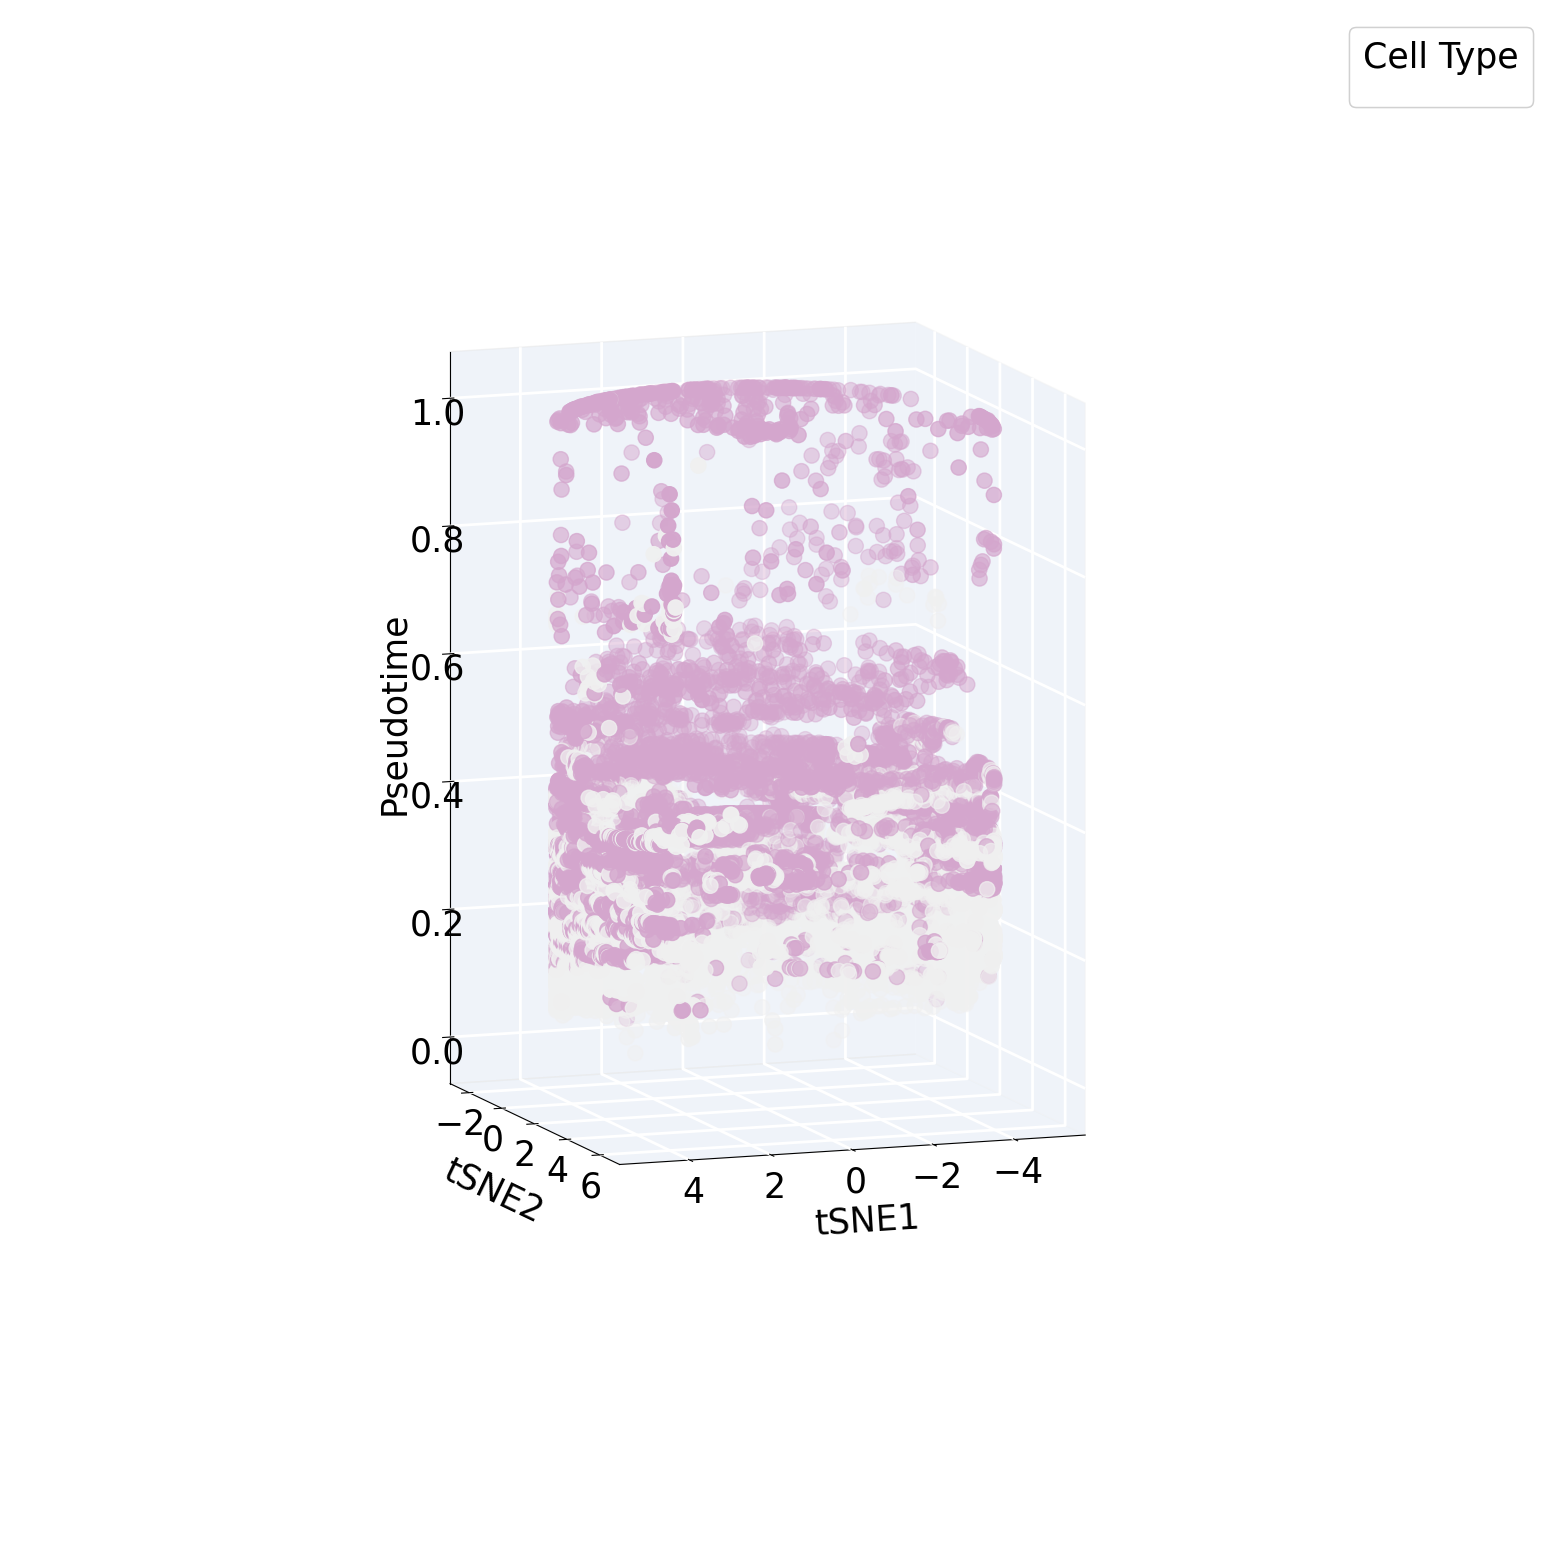

In [25]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#D4A6CD', '#f0f0f0', '#f0f0f0', '#f0f0f0']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

plt.savefig(f'GP_restingzone.svg')

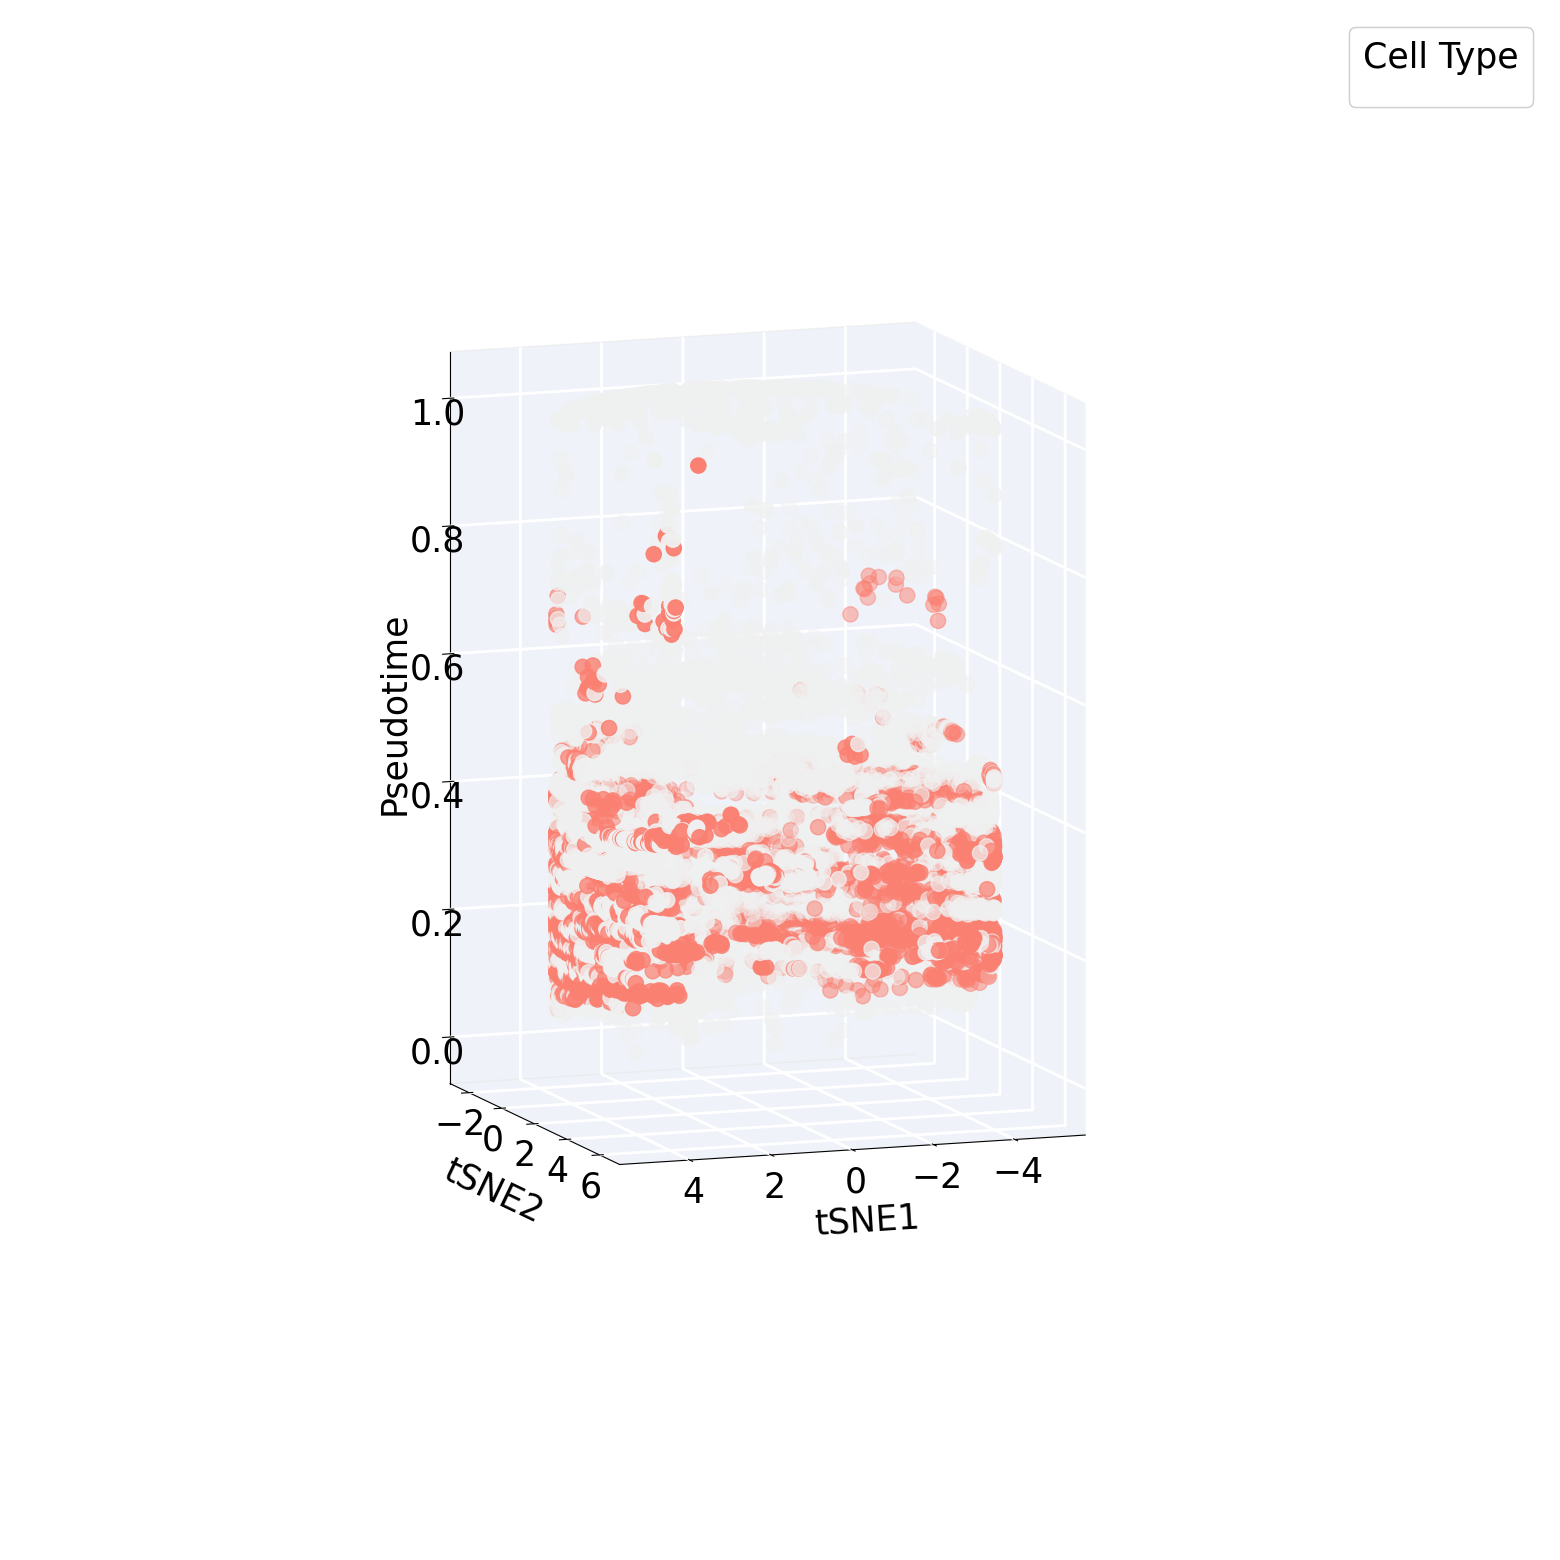

In [26]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#f0f0f0', '#FB8072', '#f0f0f0', '#f0f0f0']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

plt.savefig(f'GP_proliferative.svg')

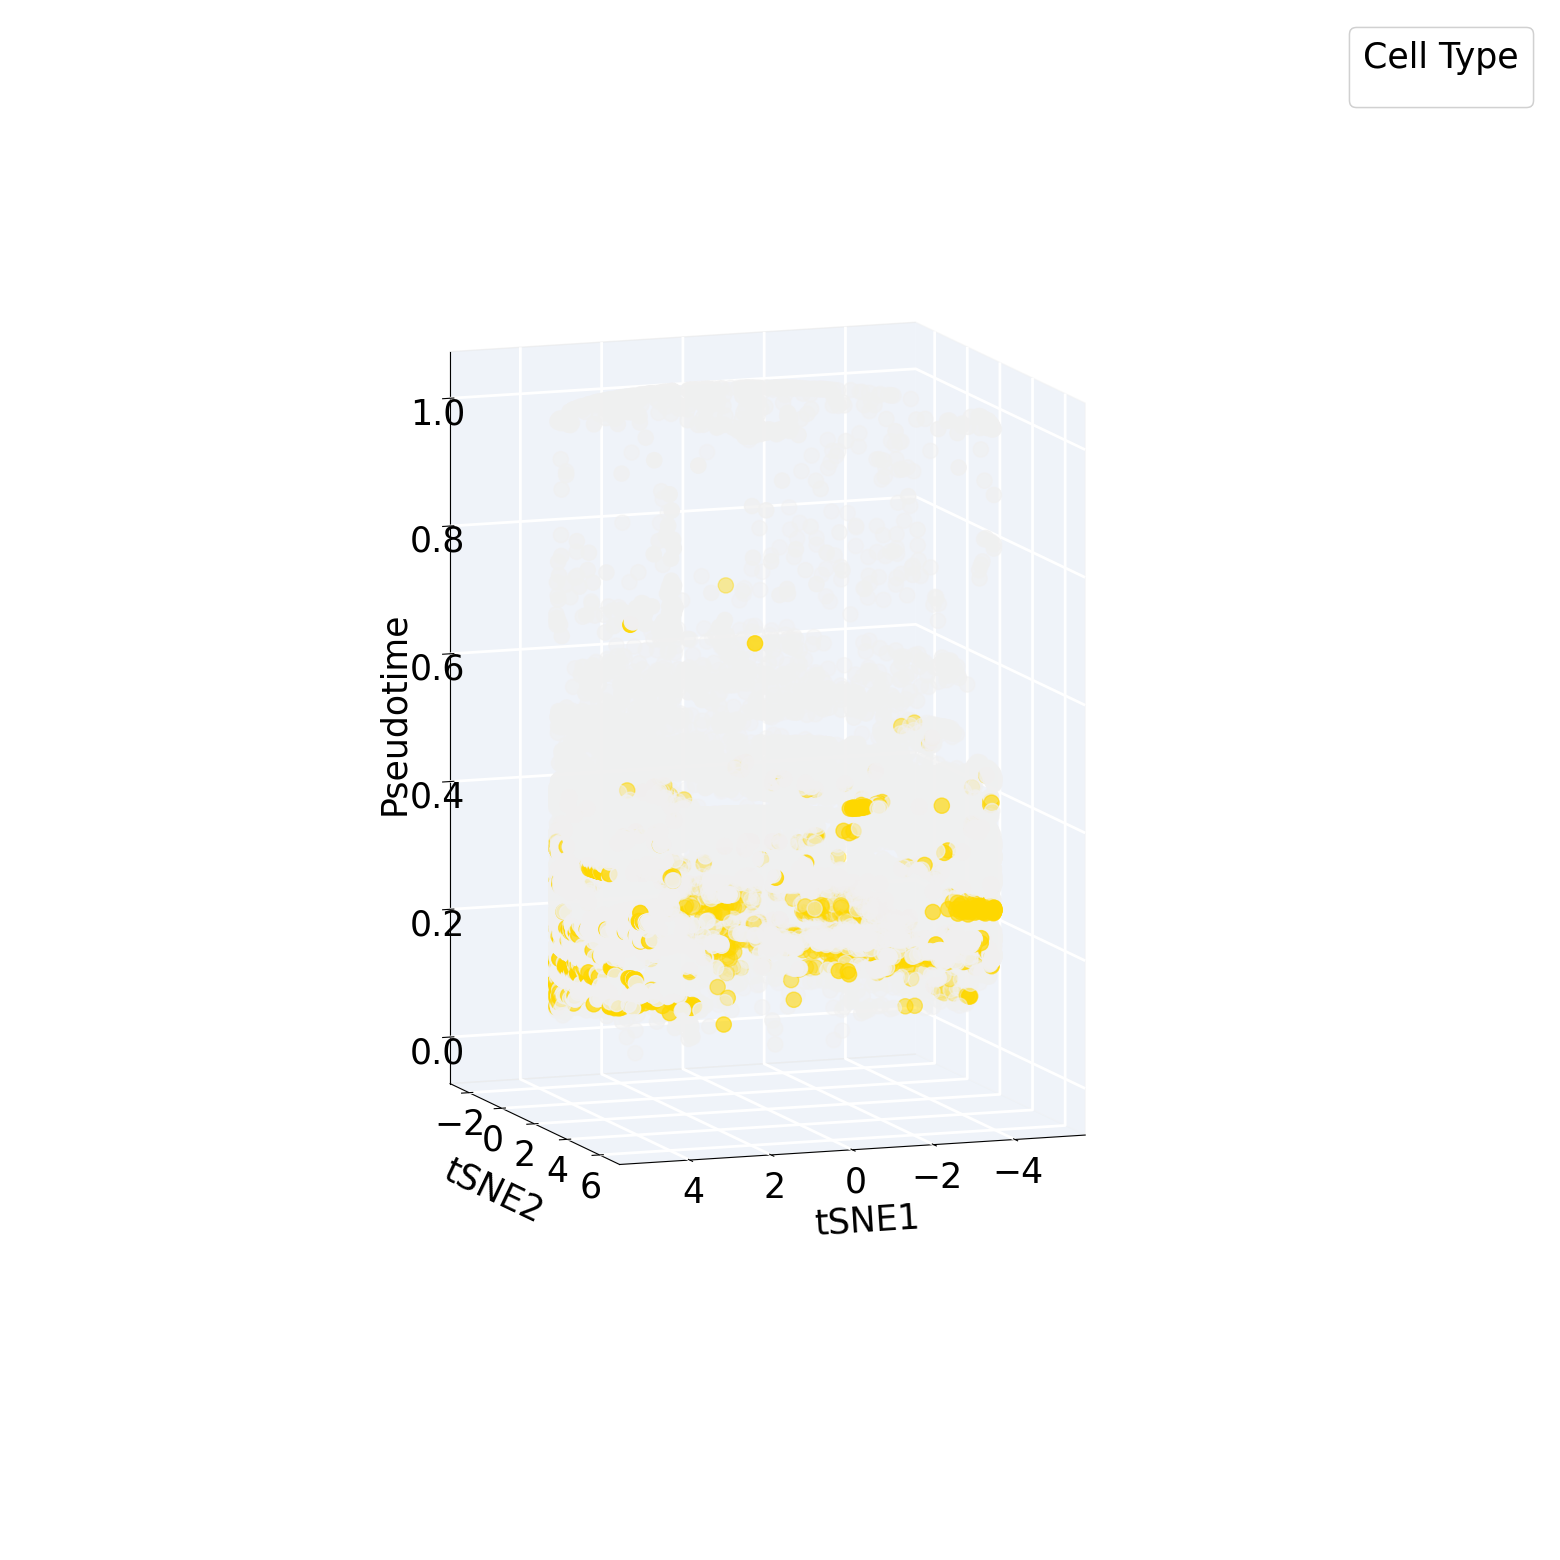

In [27]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#f0f0f0', '#f0f0f0', '#FFD700', '#f0f0f0']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

plt.savefig(f'GP_prehyp.svg')

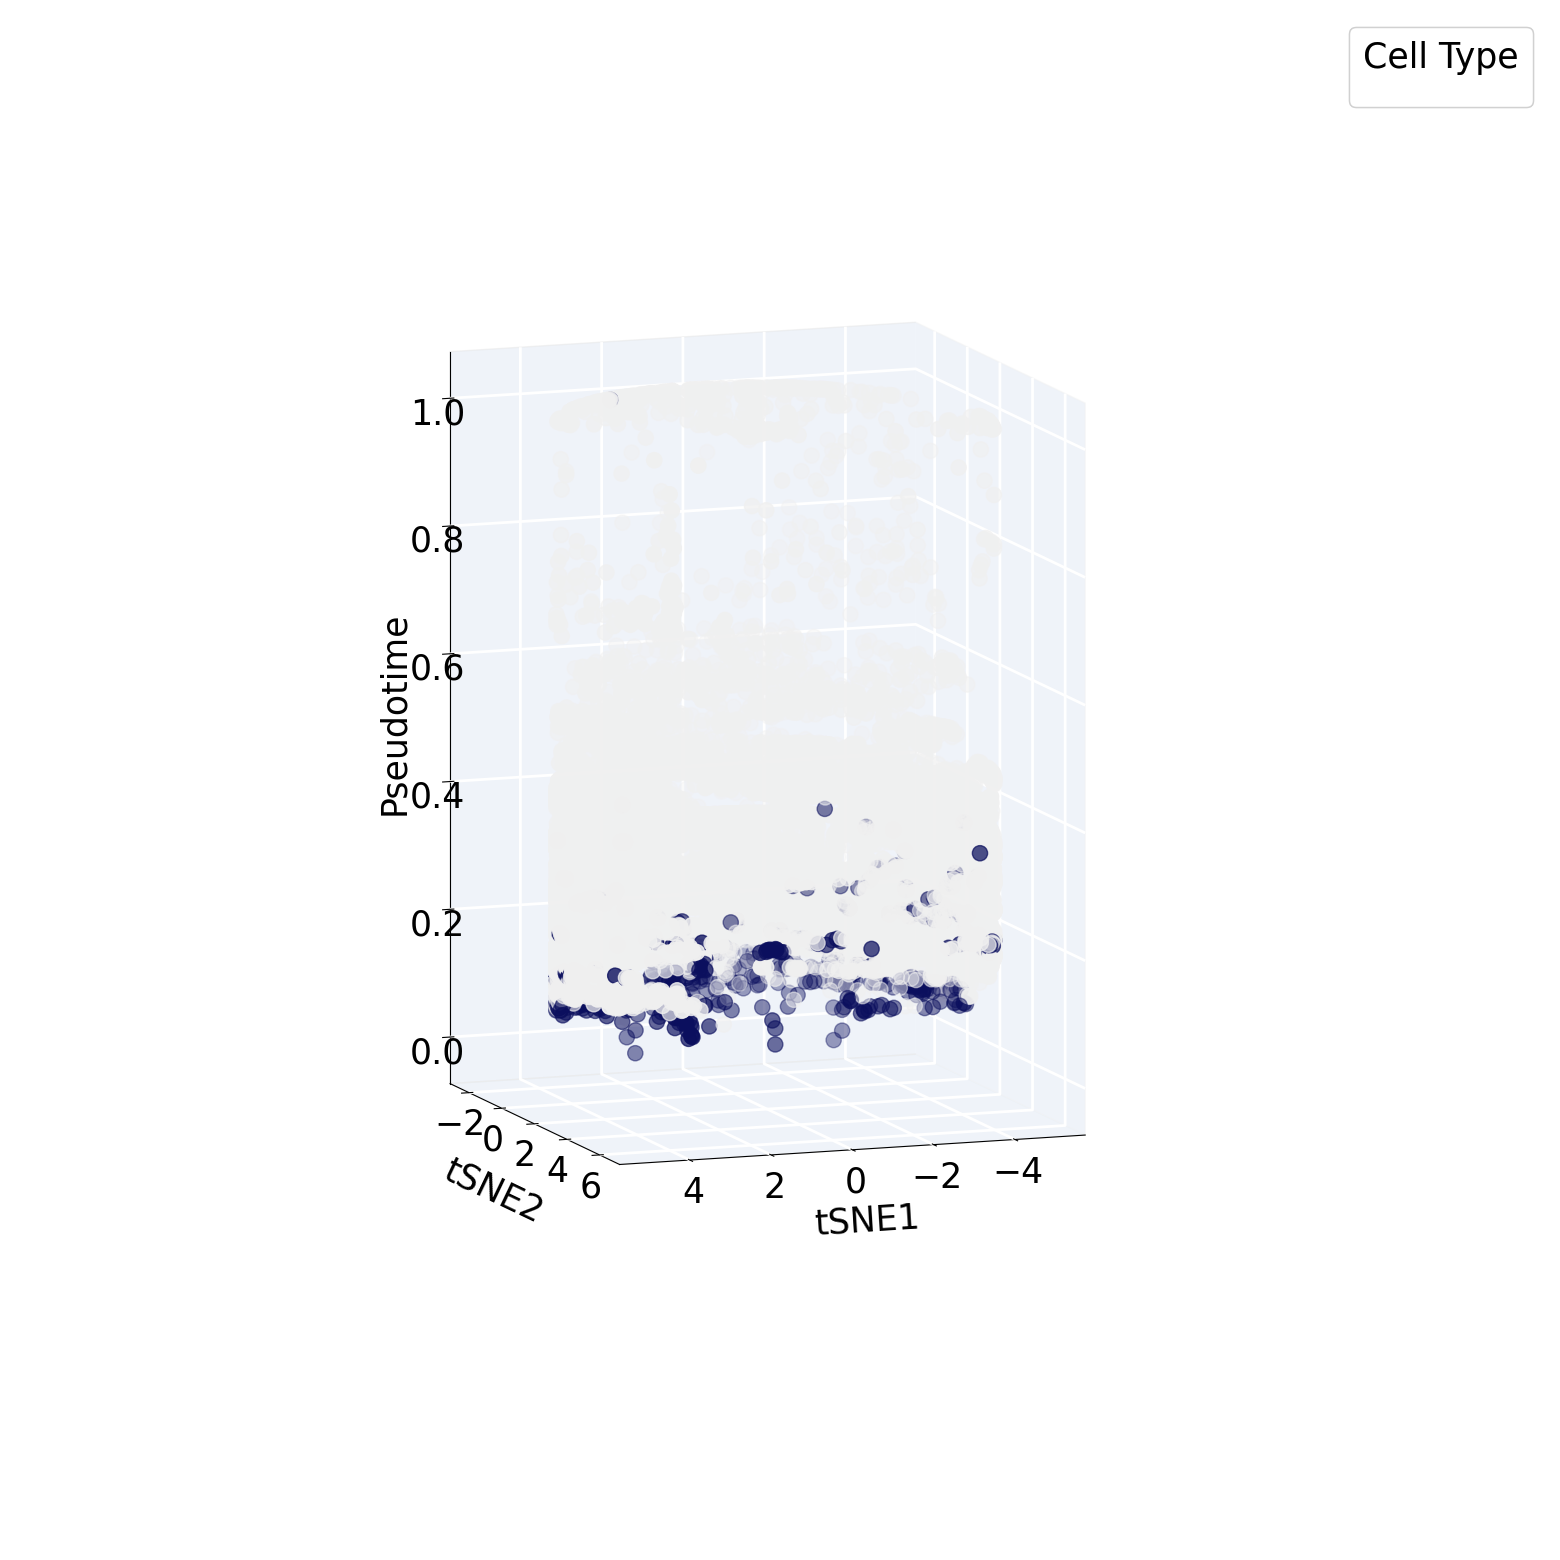

In [28]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#f0f0f0', '#f0f0f0', '#f0f0f0', '#0B0F5E']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

plt.savefig(f'GP_hyp.svg')

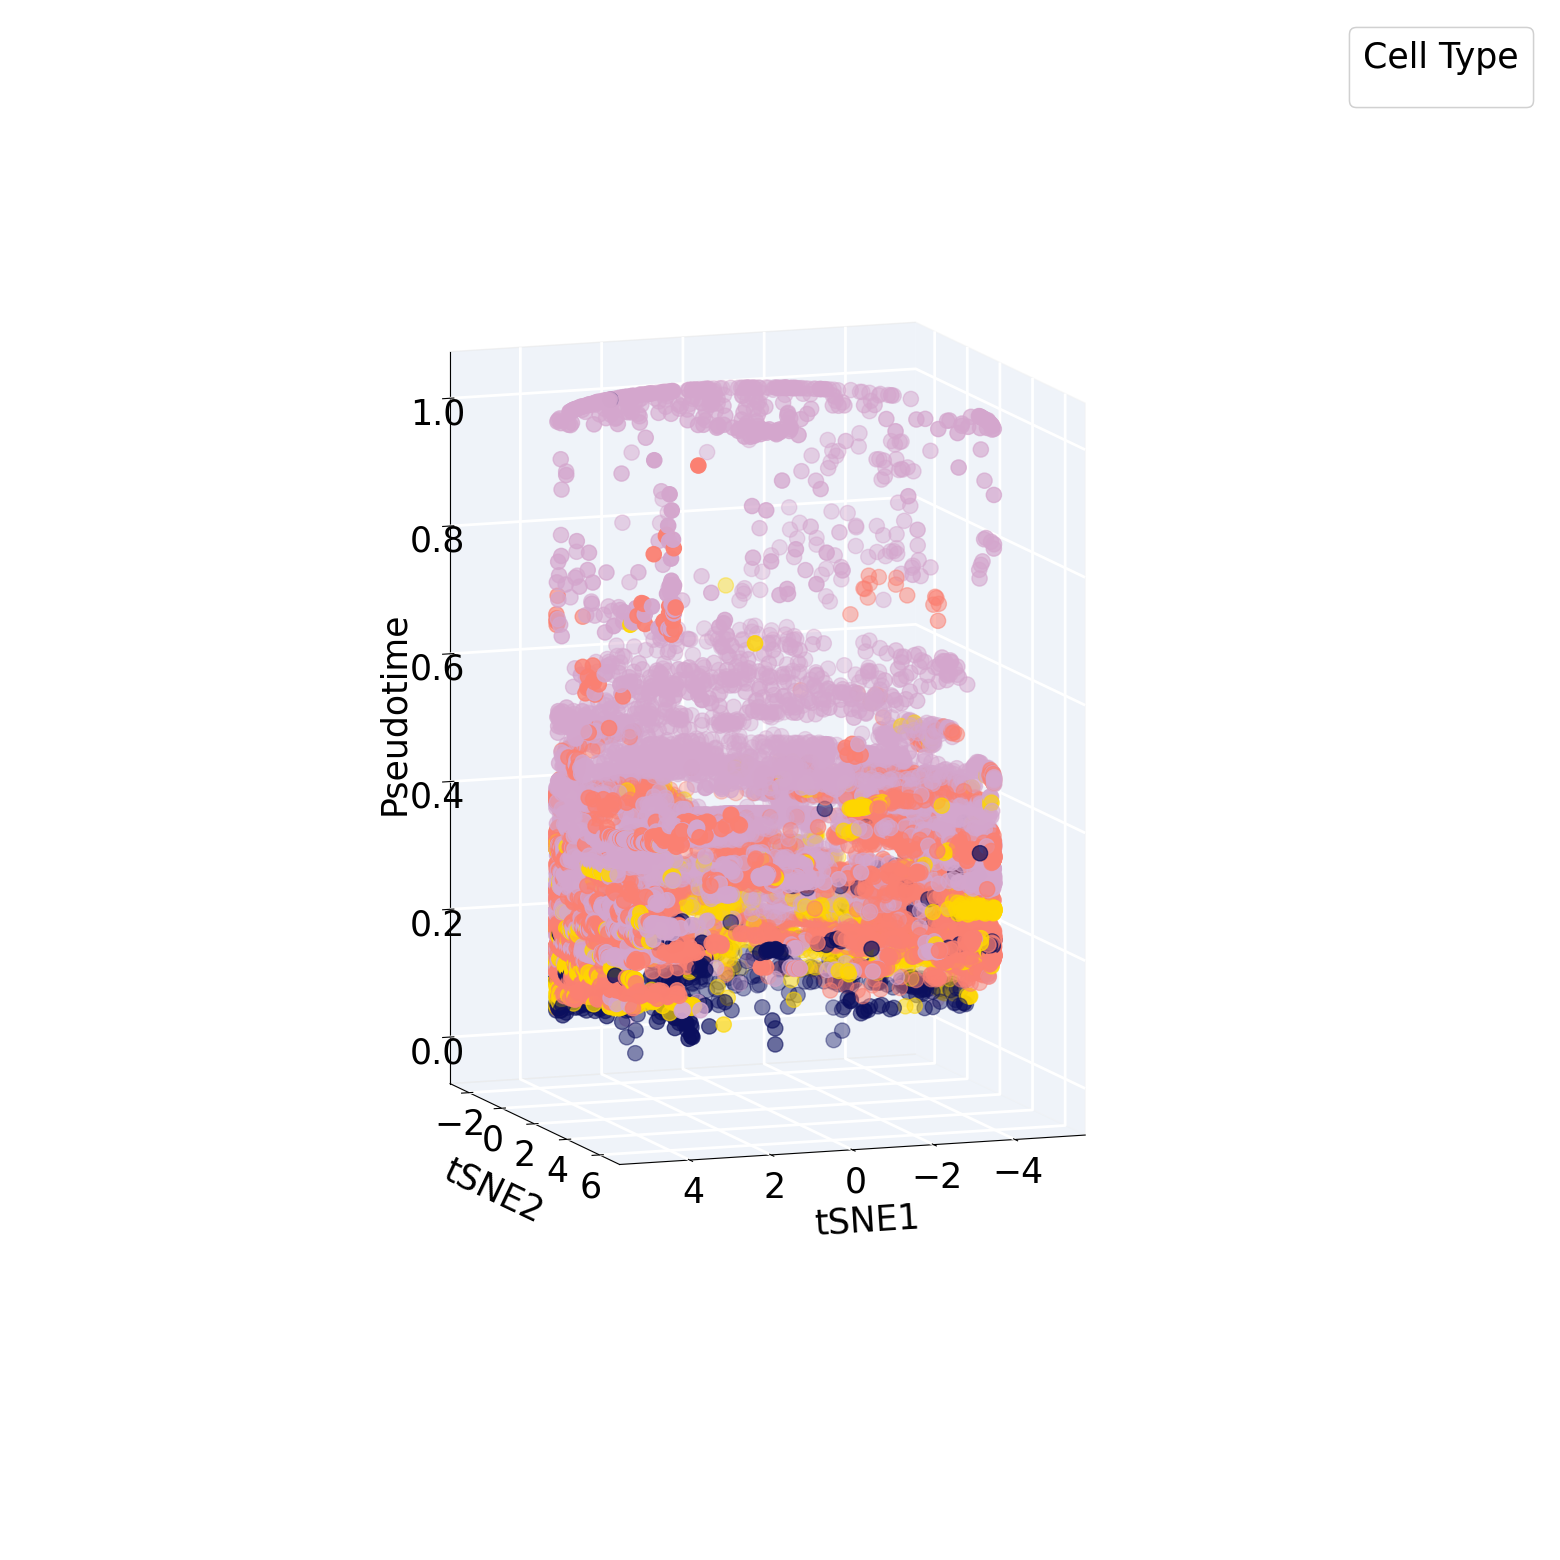

In [29]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 25})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#D4A6CD', '#FB8072', '#FFD700', '#0B0F5E']
color = pd.Index(col)[celltype_factorized]

ax.set_xlabel("tSNE1", labelpad=30)
ax.set_ylabel("tSNE2", labelpad=30)
ax.set_zlabel("Pseudotime", labelpad=30)

scatter = ax.scatter(x, y, z, s = 120, c = color)

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

legend_labelled = (scatter.legend_elements()[0],list(celltype.unique()))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*legend_labelled,
                    loc="upper right", title="Cell Type")
ax.add_artist(legend1)

# ax.legend()

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

plt.savefig(f'GP.svg')

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [31]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clr


width = 20
height = 20
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams.update({'font.size': 30})
plt.rcParams['grid.color'] = 'w'
plt.rcParams['grid.linewidth'] = 2

In [52]:
gene = 'Ihh'

In [53]:
from pathlib import Path
folder_path = "/home/host_home/Documents/Tom/Atlas/output/GP/" + gene
Path(folder_path).mkdir(parents=True, exist_ok=True)
#os.chmod(folder_path, 775)

In [54]:
plotname = folder_path + '/virtual-growth_plate_' + gene

In [55]:
gene_values = sliced_adata[:, gene].X.toarray()

In [56]:
vmin = np.percentile(gene_values, 10)
vmax = np.percentile(gene_values, 90)
# vmax=10

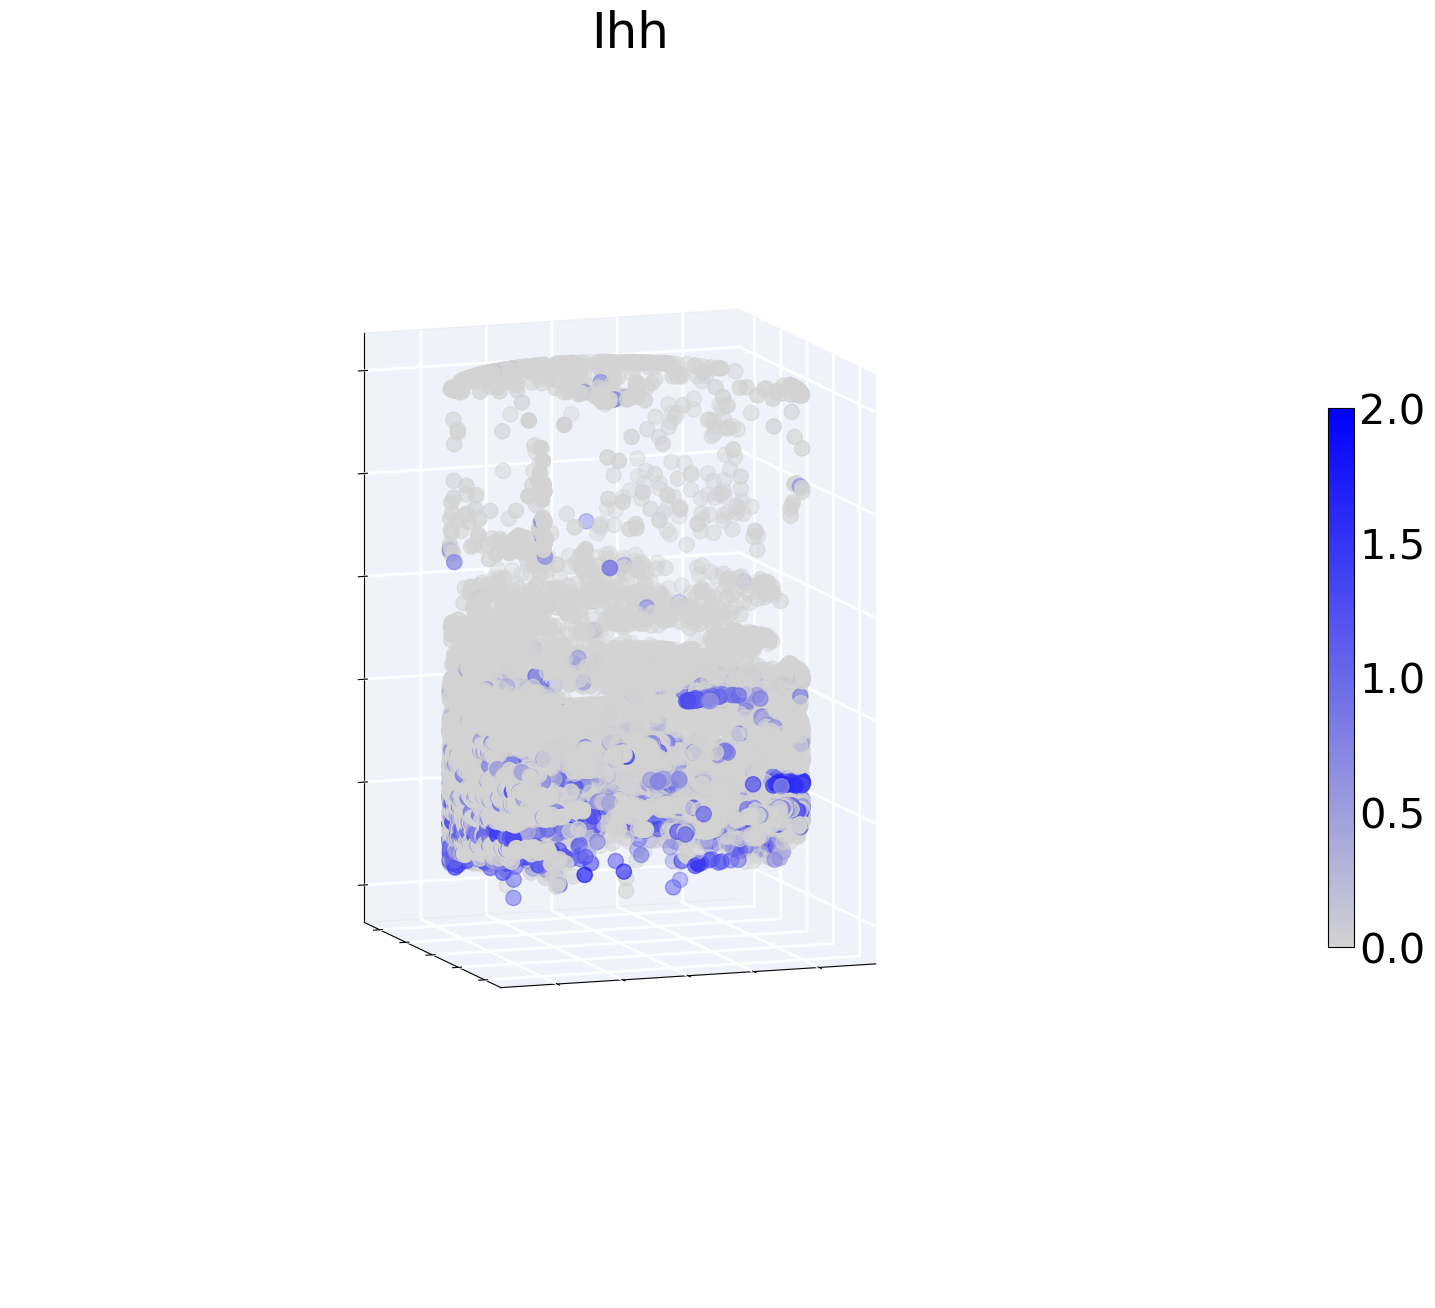

In [57]:
color_scale = ["lightgrey", "blue"]
cmap = clr.LinearSegmentedColormap.from_list('custom cmap', color_scale, N=256)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.set_proj_type('ortho')

x = sliced_adata.obsm['X_tsne'][:,0]
y = sliced_adata.obsm['X_tsne'][:,1]
norm_pseudo = sliced_adata.obs['pseudotime']/sliced_adata.obs['pseudotime'].max()
z = 1 - np.cbrt(norm_pseudo)
celltype = sliced_adata.obs['CellType']
celltype_factorized, celltype_uniques = pd.factorize( celltype )

col = ['#636dfa', '#ef553b', '#00cc96', '#FF0000']
color = pd.Index(col)[celltype_factorized]

scatter = ax.scatter(x, y, z, s = 120, c = gene_values, cmap = cmap, vmin=vmin, vmax=2)
#scatter = ax.scatter(x, y, z, s = 120, c = gene_values, cmap = cmap)
"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
"""                                                                                                                                                    
to here                                                                                                                                                
"""

ax.set_title(gene)

ax.set(yticklabels='')
ax.set(xticklabels='')
ax.set(zticklabels='')

ax.view_init(10, 70)

# Now set color to white (or whatever is "invisible")
# pane_color = [229/255,236/255,246/255]
pane_color = [224/255,233/255,245/255]
ax.xaxis.pane.set_facecolor(pane_color)
ax.yaxis.pane.set_facecolor(pane_color)
ax.zaxis.pane.set_facecolor(pane_color)

cbar = plt.colorbar(scatter, shrink=0.35)
cbar.ax.tick_params(size=0, labelsize=30)

filename = plotname + '_vector.svg'
plt.savefig(filename)